# 2. Time Series Data Recognition Practice (시계열 데이터 인식 실습)

In [22]:
import numpy as np
import shutil
folderpath= './svc2004'

# 0부터 1,599까지의 값을 가지는 배열(rand_number)을 만들고 순서를 섞음
rand_number = np.array(range(1600))
np.random.shuffle(rand_number)

n_train = 1200
n_test = 400

# 각 서명의 이름이 rand_number의 번호가 되도록 이름을 바꾸어 저장
cnt = 0

for u_id in range(1, 41):
  for s_id in range(1, 41):
    filepath_from = f'{folderpath}/U{u_id}S{s_id}.TXT'
    # 파일의 번호에 따라 학습용/테스트용 데이터로 나눔
    # 학습용 데이터인 경우
    if rand_number[cnt] < n_train:
      filepath_to = f'{folderpath}/train/{rand_number[cnt]}.TXT'
    # 테스트 데이터인 경우
    else:
      filepath_to = f'{folderpath}/test/{rand_number[cnt]}.TXT'
    shutil.move(filepath_from, filepath_to)
    cnt = cnt + 1

In [23]:
# 새롭게 바뀐 서명 데이터의 이름에는 위조 서명여부에 관한 정보가 포함되어 있지 않으므로, 이 정보를 잃어버리지 않기 위해, 각 서명의 진/위조 서명 여부를 numpy 배열에 저장한 후, csv 파일로 저장
# 각 서명의 진/위조 서명 여부를 저장
b_genuine = np.zeros((1600, 2))
b_genuine[:, 0] = range(1600)
cnt = 0
for u_id in range(1, 41):
  for s_id in range(1, 41):
    if s_id < 21:
      # 진 서명
      b_genuine[rand_number[cnt], 1] = 1
    else:
      # 위조 서명
      b_genuine[rand_number[cnt], 1] = 0
    cnt = cnt + 1

In [24]:
# csv 파일로 저장하기 위해서는 pandas 라이브러리를 사용하여 DataFrame 형식으로 변환
import pandas as pd
# 진/위조 서명 여부를 csv 파일로 저장
df_genuine = pd.DataFrame(b_genuine)
df_genuine.columns = ["ID", "bGenuine"]
df_genuine = df_genuine.astype("int32")
df_genuine.to_csv(f"{folderpath}/train_info.csv", index=False)

In [29]:
# 데이터 읽기 및 전처리
import os

# get_max_len 함수
# 파라미터로 학습 및 테스트 폴더의 모든 서명 데이터를 읽고, 전체 서명의 길이 중 가장 긴 길이의 값을 반환
def get_max_len(folderpath_train, folderpath_test):
  n_max_len = 0
  for filename in os.listdir(folderpath_train):
    filepath = f'{folderpath_train}/{filename}'
    d, tmp = load_a_sig(filepath)
    if d.shape[0] > n_max_len:
      n_max_len = d.shape[0]

  for filename in os.listdir(folderpath_test):
    filepath = f'{folderpath_test}/{filename}'
    d, tmp = load_a_sig(filepath)
    if d.shape[0] > n_max_len:
      n_max_len = d.shape[0]

  return n_max_len

In [30]:
# load_data 함수
# 파라미터로 주어진 폴더에 들어 있는 서명 파일 전체를 읽고, n_files * n_max_len * 2 크기의 numpy 배열로 만들어 반환
# 파라미터 n_max_len은 전체 서명 데이터들 중 가장 긴 서명의 길이를 의미
# 데이터와 함께 반환하는 len_sign는 각 서명의 실제 길이를 의미
def load_data(folderpath, n_max_len, sig_ids):
  # 폴더에 포함된 파일들의 리스트를 가져옴
  filelist = os.listdir(folderpath)
  # 파일의 갯수를 가져와 n_files 변수에 저장
  n_files = len(filelist)
  # n_files * n_max_len * 2 크기의 numpy 배열을 만듦
  d = np.zeros((n_files, n_max_len, 2))
  # n_files * 1 크기의 배열을 만듦. 이 변수에는 각 서명의 실제 길이를 저장
  len_sign = np.zeros(n_files)

  for i in sig_ids:
    # 파일 이름을 지정
    filepath = f'{folderpath}/{i}.TXT'
    # 서명 데이터를 읽어서 임시변수에 저장
    d_tmp, len_sign[i - sig_ids[0]] = load_a_sig(filepath)
    # 준비한 배열(d)에 저장
    d[i - sig_ids[0], :d_tmp.shape[0], :] = d_tmp
  return d, len_sign

In [31]:
# load_a_sig 함수
# 파라미터로 주어진 서명 파일을 읽고, nPoint * 2 크기의 numpy 배열로 만들어 반환
def load_a_sig(filepath):
  f = open(filepath, "rt")
  # 데이터의 첫 번째 줄을 읽어, nPoint 변수에 저장
  nPoints = int(f.readline())
  d = np.zeros((nPoints, 2))
  # 각 포인트의 갯수만큼 반복하면서 각각의 줄을 읽고, X, y 좌표를 분리하여 저장
  for i in range(nPoints):
    line = f.readline()
    toks = line.split(" ")
    d[i, :] = [int(toks[0]), int(toks[1])]
  f.close()
  return d, nPoints

In [32]:
# 위 함수를 사용하여 데이터를 읽음
# 각 데이터의 길이를 체크하고 최대 길이 확인
n_max_len = get_max_len(f'{folderpath}/train', f'{folderpath}/test')
# 학습용 데이터 load
X_train, X_train_len = load_data(f'{folderpath}/train', n_max_len, range(n_train))
# 테스트용 데이터 load
X_test, X_test_len = load_data(f'{folderpath}/test', n_max_len, range(n_train, 1600))

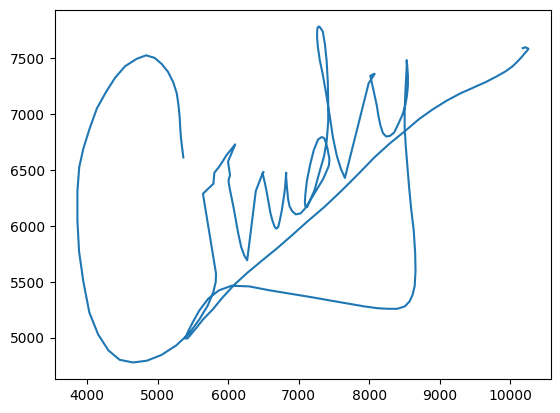

In [34]:
# 읽어온 데이터는 매우 다양한 값을 가지므로 정규화 작업이 필요
# 현재 데이터가 어떻게 구성되어 있는지 plot 함수를 사용하여 확인
import matplotlib.pyplot as plt
s_id = 10
len_sig = int(X_train_len[s_id])
plt.plot(X_train[s_id, :len_sig, 0], X_train[s_id, :len_sig, 1]);

In [37]:
# 서명 데이터의 값을 0에서 1 사이의 값으로 정규화
# 서명은 높이/너비의 비율이 중요하므로, 이 정보를 잃지 않도록 이 비율을 미리 계산해 두고, 마지막에 곱하여 y 값을 보정
for i in range(X_train.shape[0]):
  len_tmp = int(X_train_len[i])
  h_min = np.min(X_train[i, :len_tmp, 0])
  h_max = np.max(X_train[i, :len_tmp, 0])
  v_min = np.min(X_train[i, :len_tmp, 1])
  v_max = np.max(X_train[i, :len_tmp, 1])
  # 너비-높이 비율
  w_h_ratio = (v_max - v_min) / (h_max - h_min)

  X_train[i, :len_tmp, 0] = (X_train[i, :len_tmp, 0] - h_min) / (h_max - h_min)
  X_train[i, :len_tmp, 1] = (X_train[i, :len_tmp, 1] - v_min) / (v_max - v_min) * w_h_ratio

for i in range(X_test.shape[0]):
  len_tmp = int(X_test_len[i])
  h_min = np.min(X_test[i, :len_tmp, 0])
  h_max = np.max(X_test[i, :len_tmp, 0])
  v_min = np.min(X_test[i, :len_tmp, 1])
  v_max = np.max(X_test[i, :len_tmp, 1])

  w_h_ratio = (v_max - v_min) / (h_max - h_min)

  X_test[i, :len_tmp, 0] = (X_test[i, :len_tmp, 0] - h_min) / (h_max - h_min)
  X_test[i, :len_tmp, 1] = (X_test[i, :len_tmp, 1] - v_min) / (v_max - v_min) * w_h_ratio

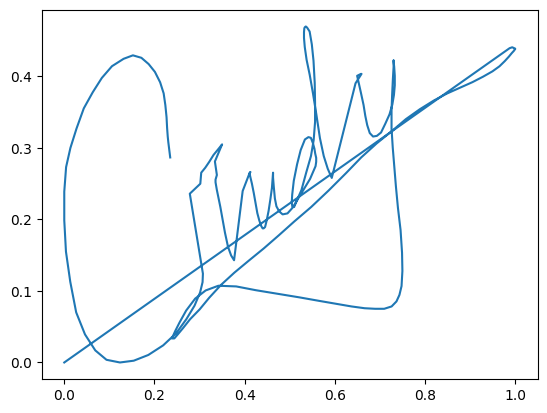

In [38]:
# 배열의 값을 끝까지 그렸으므로 서명의 뒷부분 좌표가 (0, 0)으로 되어있음
s_id = 10
plt.plot(X_train[s_id, :, 0], X_train[s_id, :, 1]);

In [39]:
# 읽어온 데이터의 진/위조 서명 여부 정보를 파일에서 읽고, 학습/테스트용 값으로 분리
from tensorflow import keras

y_pd = pd.read_csv(f'{folderpath}/train_info.csv')
y_all = np.array(y_pd['bGenuine'])
y_train = y_all[:n_train]
y_train_cat = keras.utils.to_categorical(y_train)
y_test = y_all[n_train:]

In [60]:
# 모델 구조 지정
# 합성곱층 6새, MaxPooling층 3개, LSTM층 1개, 완전 연결층 1개로 네트워크 구조 구성
# 완전 연결층의 앞에는 드롭아웃층을 추가하여 오버피팅 방지
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

# 모델 구조 지정
model = Sequential()
model.add(Conv1D(8, kernel_size=3, padding="same", activation="relu"))
model.add(Conv1D(8, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=3, strides=2))

model.add(Conv1D(16, kernel_size=3, padding="same", activation="relu"))
model.add(Conv1D(16, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=3, strides=2, input_dim=2))

model.add(Conv1D(32, kernel_size=3, padding="same", activation="relu"))
model.add(Conv1D(32, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=3, strides=2, input_dim=2))

model.add(Bidirectional(LSTM(128)))

model.add(Dropout(0.3))
model.add(Dense(units=2, activation="Softmax"))

In [63]:
from tensorflow.keras.optimizers import Adam

# 모델 컴파일, 학습
# Adam Optimizer를 사용하고, 학습률을 0.001로 설정
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
# 학습
hist = model.fit(x=X_train, y=y_train_cat, epochs=80, validation_split=0.3, batch_size=16)

Epoch 1/80



53/53 [==============================] - 7s 70ms/step - loss: 0.6957 - accuracy: 0.5024 - val_loss: 0.6929 - val_accuracy: 0.5056
Epoch 2/80
53/53 [==============================] - 3s 57ms/step - loss: 0.6921 - accuracy: 0.5143 - val_loss: 0.6886 - val_accuracy: 0.5333
Epoch 3/80
53/53 [==============================] - 3s 54ms/step - loss: 0.7026 - accuracy: 0.5429 - val_loss: 0.7010 - val_accuracy: 0.5389
Epoch 4/80
53/53 [==============================] - 3s 54ms/step - loss: 0.6990 - accuracy: 0.5595 - val_loss: 0.6777 - val_accuracy: 0.5528
Epoch 5/80
53/53 [==============================] - 3s 58ms/step - loss: 0.6916 - accuracy: 0.5702 - val_loss: 0.6831 - val_accuracy: 0.5444
Epoch 6/80
53/53 [==============================] - 3s 54ms/step - loss: 0.6612 - accuracy: 0.6083 - val_loss: 0.6671 - val_accuracy: 0.6056
Epoch 7/80
53/53 [==============================] - 3s 55ms/step - loss: 0.6607 - accuracy: 0.6036 - val_loss: 0.6774 - val_accuracy: 0.5611
Epoch 8/80

In [64]:
# 테스트
o = model.predict(X_test)

# 정확도 체크
o = np.argmax(o, 1)
sum(np.equal(y_test, o) / len(y_test))

13/13 [==============================] - 1s 23ms/step


0.842499999999993